In [1]:
import torch

# 基础

In [9]:
x_data = [1.0, 2.0, 3.0]
y_data = [2.0, 4.0, 6.0]

In [10]:
w = torch.Tensor([1.0]) # 由list生成tensor，这里权重就是一个标量
w.requires_grad = True # 用于自动求梯度，该参数设为True
                        #（如果不设为True，意味我们不需要这个参数的梯度，不会在backward时自动计算grad参数）

In [11]:
print(w)
print(w.item())
print(w.data)
print(w.type())             # a的类型是tensor
print(w.data.type())        # a.data的类型是tensor
print(w.grad)
print(type(w.grad))

tensor([ 1.])
1.0
tensor([ 1.])
torch.FloatTensor
torch.FloatTensor
None
<class 'NoneType'>


### 代码的本质是构建计算图

In [14]:
def forward(x):
    ''' 模型 '''
    return x * w # w是一个tensor，这里*被重载了，进行的是Tensor间的数乘（x会被自动转换为张量）
    # 包含tensor对象的运算，关于这个tensor就会产生计算图！

In [15]:
def loss(x, y):
    y_pred = forward(x) # 模型输入x的输出
    return (y_pred-y) ** 2 # 由输出和标签计算当前样本loss

In [16]:
print("predict (before training)", 4, forward(4).item())
 
# 用的依然是原版的随机梯度下降，即每个epoch的每次迭代
for epoch in range(100):
    for x, y in zip(x_data, y_data):
        l = loss(x,y) # forward计算loss: l是一个tensor
        l.backward() # 自动将计算l的链路上的每一个（设置为True）的张量计算梯度
        # 注意：每一次backward都会使计算图释放，下次forward就重新构建计算图
        print('\tgrad:', x, y, w.grad.item())
        w.data = w.data - 0.01 * w.grad.data   # 权重更新时，注意grad也是一个tensor
        # 所以权重更新（即权重数值的修改/计算，而非模型的计算）时，要使用data属性而不是用tensor对象本身，因为使用tensor对象会构建计算图！
        # 这与打印时要使用.item()是相同的道理，使用一个标量，避免产生计算图
        
        '''
        计算整体损失时，如果写
        sum += l
        一旦有tensor对象参与运算就会构建计算图，由于没有backward，导致这个计算图不停的扩大（每次增加一个加法结点），把内存都吃光了
        所以要写成 sum += l.item()
        注意！.item()方法只有在tensor只有一个元素时才可以调用，用于将张量转换为一个标量
        '''
        w.grad.data.zero_() # after update, remember set the grad to zero
        '''
        如果不清零，第一次L1对w的偏导还保留着，第二次算梯度时就是 【L1对w偏导+L2对w偏导】，即会造成梯度的累加
        在有些情况下我们可能会需要梯度的累加
        '''
 
    print('progress:', epoch, l.item()) # 取出loss使用l.item，不要直接使用l（l是tensor会构建计算图）
 
print("predict (after training)", 4, forward(4).item())

predict (before training) 4 4.0
	grad: 1.0 2.0 -2.0
	grad: 2.0 4.0 -7.840000152587891
	grad: 3.0 6.0 -16.228801727294922
progress: 0 7.315943717956543
	grad: 1.0 2.0 -1.478623867034912
	grad: 2.0 4.0 -5.796205520629883
	grad: 3.0 6.0 -11.998146057128906
progress: 1 3.9987640380859375
	grad: 1.0 2.0 -1.0931644439697266
	grad: 2.0 4.0 -4.285204887390137
	grad: 3.0 6.0 -8.870372772216797
progress: 2 2.1856532096862793
	grad: 1.0 2.0 -0.8081896305084229
	grad: 2.0 4.0 -3.1681032180786133
	grad: 3.0 6.0 -6.557973861694336
progress: 3 1.1946394443511963
	grad: 1.0 2.0 -0.5975041389465332
	grad: 2.0 4.0 -2.3422164916992188
	grad: 3.0 6.0 -4.848389625549316
progress: 4 0.6529689431190491
	grad: 1.0 2.0 -0.4417421817779541
	grad: 2.0 4.0 -1.7316293716430664
	grad: 3.0 6.0 -3.58447265625
progress: 5 0.35690122842788696
	grad: 1.0 2.0 -0.3265852928161621
	grad: 2.0 4.0 -1.2802143096923828
	grad: 3.0 6.0 -2.650045394897461
progress: 6 0.195076122879982
	grad: 1.0 2.0 -0.24144840240478516
	grad: 2.

### 二次模型

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import torch

x_data = [1.0,2.0,3.0]
y_data = [2.0,4.0,6.0]

w1 = torch.Tensor([1.0])#初始权值
w1.requires_grad = True#计算梯度，默认是不计算的
w2 = torch.Tensor([1.0])
w2.requires_grad = True
b = torch.Tensor([1.0])
b.requires_grad = True

def forward(x):
    return w1 * x**2 + w2 * x + b

def loss(x,y):#构建计算图
    y_pred = forward(x)
    return (y_pred-y) **2

print('Predict (befortraining)',4,forward(4))

for epoch in range(100):
    l = loss(1, 2)#为了在for循环之前定义l,以便之后的输出，无实际意义
    for x,y in zip(x_data,y_data):
        l = loss(x, y)
        l.backward()
        print('\tgrad:',x,y,w1.grad.item(),w2.grad.item(),b.grad.item())
        w1.data = w1.data - 0.01*w1.grad.data #注意这里的grad是一个tensor，所以要取他的data
        w2.data = w2.data - 0.01 * w2.grad.data
        b.data = b.data - 0.01 * b.grad.data
        w1.grad.data.zero_() #释放之前计算的梯度
        w2.grad.data.zero_()
        b.grad.data.zero_()
    print('Epoch:',epoch,l.item())

print('Predict(after training)',4,forward(4).item())


Predict (befortraining) 4 tensor([ 21.])
	grad: 1.0 2.0 2.0 2.0 2.0
	grad: 2.0 4.0 22.880001068115234 11.440000534057617 5.720000267028809
	grad: 3.0 6.0 77.04720306396484 25.682401657104492 8.560800552368164
Epoch: 0 18.321826934814453
	grad: 1.0 2.0 -1.1466078758239746 -1.1466078758239746 -1.1466078758239746
	grad: 2.0 4.0 -15.536651611328125 -7.7683258056640625 -3.8841629028320312
	grad: 3.0 6.0 -30.432214736938477 -10.144071578979492 -3.381357192993164
Epoch: 1 2.858394145965576
	grad: 1.0 2.0 0.3451242446899414 0.3451242446899414 0.3451242446899414
	grad: 2.0 4.0 2.4273414611816406 1.2136707305908203 0.6068353652954102
	grad: 3.0 6.0 19.449920654296875 6.483306884765625 2.161102294921875
Epoch: 2 1.1675907373428345
	grad: 1.0 2.0 -0.32242679595947266 -0.32242679595947266 -0.32242679595947266
	grad: 2.0 4.0 -5.845773696899414 -2.922886848449707 -1.4614434242248535
	grad: 3.0 6.0 -3.8828859329223633 -1.294295310974121 -0.43143177032470703
Epoch: 3 0.04653334245085716
	grad: 1.0 2.0 

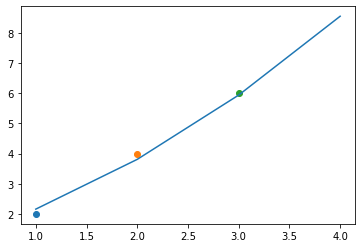

In [22]:
func = lambda x:w1.item()*(x**2)+w2.item()*x+b.item()
t_list = np.array([1,2,3,4])
plt.plot(t_list, func(t_list))
plt.scatter(1,2)
plt.scatter(2,4)
plt.scatter(3,6)